
image 1/1 c:\Users\soura\Downloads\ML-Model\ed\images\1 (4).png: 640x576 141.6ms
Speed: 22.2ms preprocess, 141.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 576)


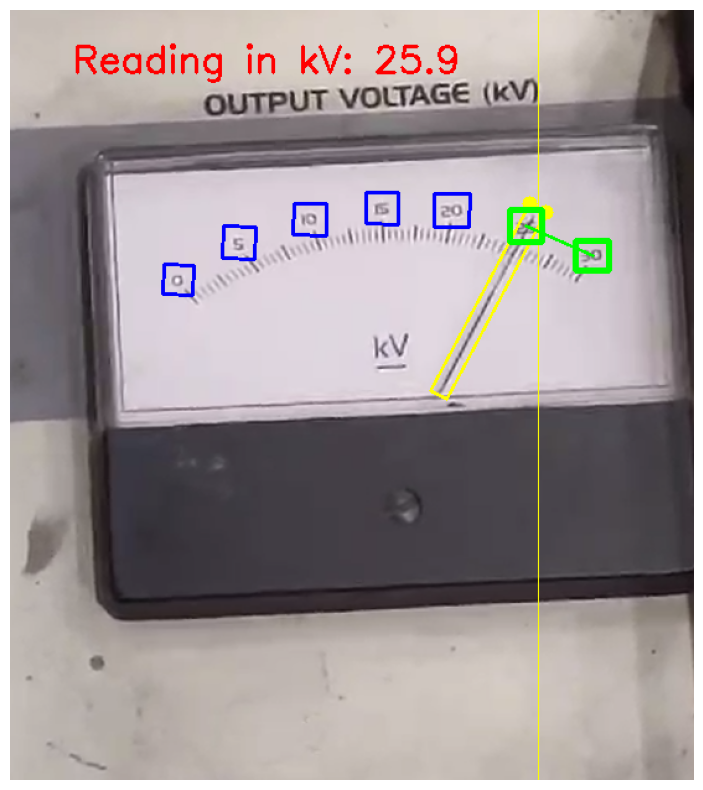

Meter reading in kV: 25.9


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load trained model
model = YOLO("Models/best.pt")

def get_meter_reading(image_path, model):
    results = model(image_path, conf=0.2)
    obb_data = results[0].obb
    class_names = results[0].names

    if obb_data is None:
        return "No objects detected"

    image = cv2.imread(image_path)
    number_positions = []
    needle_corners = None
    number_values = [0, 5, 10, 15, 20, 25, 30]
    
    # Extract corners for needle and numbers
    for i, class_id in enumerate(obb_data.cls.cpu().numpy()):
        class_name = class_names[int(class_id)]
        if hasattr(obb_data, "xyxyxyxy") and obb_data.xyxyxyxy is not None:
            corners_flat = obb_data.xyxyxyxy.cpu().numpy()[i]
            corners = np.array(corners_flat).reshape(4, 2)
            
            if class_name.lower() == "needle":
                needle_corners = corners
                # Draw bounding box for needle
                cv2.polylines(image, [corners.astype(np.int32)], isClosed=True, color=(0, 255, 255), thickness=2)
                
                # Only show coordinates for corners 3 and 4 (the needle tips)
                for j in [2, 3]:  # corners 3 and 4 (index 2 and 3)
                    corner = corners[j]
                    cv2.circle(image, (int(corner[0]), int(corner[1])), 6, (0, 255, 255), -1)
                    
            elif class_name.lower() == "numbers":
                # Calculate center point for sorting
                center_x = np.mean(corners[:, 0])
                number_positions.append((corners, center_x))
                # Draw simple bounding box for number
                cv2.polylines(image, [corners.astype(np.int32)], isClosed=True, color=(255, 0, 0), thickness=2)
    
    # Sort number positions from left to right based on center x-coordinate
    number_positions.sort(key=lambda x: x[1])
    
    # Assign values to sorted number positions
    labeled_numbers = []
    for i, (corners, center_x) in enumerate(number_positions):
        if i < len(number_values):
            value = number_values[i]
            # Get x-range of this number box
            min_x = np.min(corners[:, 0])
            max_x = np.max(corners[:, 0])
            center_x = np.mean(corners[:, 0])
            labeled_numbers.append((corners, value, center_x, min_x, max_x))
            # Add value label
            
    
    # Get needle position
    interpolated_value = None
    if needle_corners is not None and labeled_numbers:
        # Calculate average x position of needle tips (corners 3 and 4)
        needle_tip1_x = needle_corners[2][0]  # Corner 3 x-coordinate
        needle_tip2_x = needle_corners[3][0]  # Corner 4 x-coordinate
        needle_tip_avg_x = (needle_tip1_x + needle_tip2_x) / 2
        
        # Draw vertical line at needle position
        cv2.line(image, (int(needle_tip_avg_x), 0), (int(needle_tip_avg_x), image.shape[0]), (0, 255, 255), 1)
        
        # Find the two adjacent number values
        left_value = None
        right_value = None
        left_center_x = None
        right_center_x = None
        
        # Sort labeled_numbers by center_x for finding left and right neighbors
        sorted_numbers = sorted(labeled_numbers, key=lambda x: x[2])
        
        # Find the two values that the needle is between
        for corners, value, center_x, min_x, max_x in sorted_numbers:
            if center_x <= needle_tip_avg_x:
                left_value = value
                left_center_x = center_x
                left_corners = corners
            else:
                right_value = value
                right_center_x = center_x
                right_corners = corners
                break
        
        # If needle is before the first value
        if left_value is None and right_value is not None:
            interpolated_value = right_value
            cv2.polylines(image, [right_corners.astype(np.int32)], isClosed=True, color=(0, 0, 255), thickness=3)
            
        # If needle is after the last value
        elif right_value is None and left_value is not None:
            interpolated_value = left_value
            cv2.polylines(image, [left_corners.astype(np.int32)], isClosed=True, color=(0, 0, 255), thickness=3)
            
        # If needle is between two values, interpolate
        elif left_value is not None and right_value is not None:
            # Calculate the ratio based on x positions
            total_distance = right_center_x - left_center_x
            if total_distance > 0:  # Avoid division by zero
                needle_distance = needle_tip_avg_x - left_center_x
                ratio = needle_distance / total_distance
                
                # Interpolate between the two values
                value_range = right_value - left_value
                interpolated_value = left_value + (ratio * value_range)
                
                # Highlight both adjacent number boxes
                cv2.polylines(image, [left_corners.astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=3)
                cv2.polylines(image, [right_corners.astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=3)
                
                # Draw line connecting the two adjacent values
                left_pt = (int(left_center_x), int(np.mean(left_corners[:, 1])))
                right_pt = (int(right_center_x), int(np.mean(right_corners[:, 1])))
                cv2.line(image, left_pt, right_pt, (0, 255, 0), 2)
                
    # Display result on image
    if interpolated_value is not None:
        # Round to 1 decimal place for display
        rounded_value = round(interpolated_value, 1)
        cv2.putText(image, f"Reading in kV: {rounded_value}", (50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2)
        
    # Display the image with annotations
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    if interpolated_value is not None:
        return round(interpolated_value, 1)
    else:
        return "Needle position could not be determined"

image_path = "ed/images/1 (4).png"
result = get_meter_reading(image_path, model)
print(f"Meter reading in kV: {result}")